#  Transfer Learning - ResNet50

In [1]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import imghdr

import seaborn as sns

from PIL import Image


import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

2024-07-24 02:44:28.254806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 02:44:28.254905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 02:44:28.380101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # To minimize TensorFlow logging output
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable oneDNN optimizations


tf.config.optimizer.set_jit(True)  # Enable XLA

In [3]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(rescale=1/255,                # Rescale pixel values to [0, 1]
                                  rotation_range=40,            # Randomly rotate images in the range (degrees, 0 to 180)
                                  width_shift_range=0.2,        # Randomly horizontally shift images
                                  height_shift_range=0.2,       # Randomly vertically shift images
                                  shear_range=0.2,              # Apply shearing transformations
                                  zoom_range=0.1,               # Randomly zoom image
                                  horizontal_flip=True,         # Randomly flip images horizontally
                                  fill_mode='nearest'           # Strategy used for filling in newly created pixels
)


# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(
                                  rescale=1/255                 # Rescale pixel values to [0, 1]
                              )

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=32                 # Size of the batches of data
                                                )

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(224, 224),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=32                 # Size of the batches of data
                                              )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [5]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


2024-07-24 02:47:18.709987: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [8]:
# Evaluate the model on the test data to get the initial loss and accuracy
initial_loss, initial_accuracy = model.evaluate(test_generator, verbose=2)

# Print the initial loss and accuracy
print(f"Initial loss: {initial_loss}")
print(f"Initial accuracy: {initial_accuracy}")

I0000 00:00:1721789304.797592     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 - 67s - 298ms/step - accuracy: 0.1179 - loss: 2.3984
Initial loss: 2.398413896560669
Initial accuracy: 0.11786013096570969


In [ ]:
#from tensorflow.keras.models import load_model

In [ ]:
'''model_path = '/kaggle/input/resnet50_100epochs_human_emotions/tensorflow2/base100epochs/1/ResNet50_Transfer_Learning.keras'
ResNet50_model_v2 = load_model(model_path)
optimizer = Adam(learning_rate=0.0001)
ResNet50_model_v2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
ResNet50_model_v2.summary() '''

In [10]:
# File path for the model checkpoint
cnn_path = '/kaggle/working/'
name = 'ResNet50_model_v1_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
'''
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True)
                          '''

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=8,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'ResNet50_model_v1_training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint,csv_logger,reduce_lr]  # Adjusted as per your use-case

In [11]:
train_history = model.fit(
                          train_generator,
                          epochs=20,
                          validation_data=test_generator, 
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                        )

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.2306 - loss: 1.8642
Epoch 1: val_loss improved from inf to 1.48416, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 639s 638ms/step - accuracy: 0.2307 - loss: 1.8641 - val_accuracy: 0.4496 - val_loss: 1.4842 - learning_rate: 1.0000e-04
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4213 - loss: 1.5020
Epoch 2: val_loss improved from 1.48416 to 1.21364, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 331s 366ms/step - accuracy: 0.4213 - loss: 1.5019 - val_accuracy: 0.5401 - val_loss: 1.2136 - learning_rate: 1.0000e-04
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4952 - loss: 1.3184
Epoch 3: val_loss improved from 1.21364 to 1.14662, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 331s 365ms/step - accuracy: 0.4952 

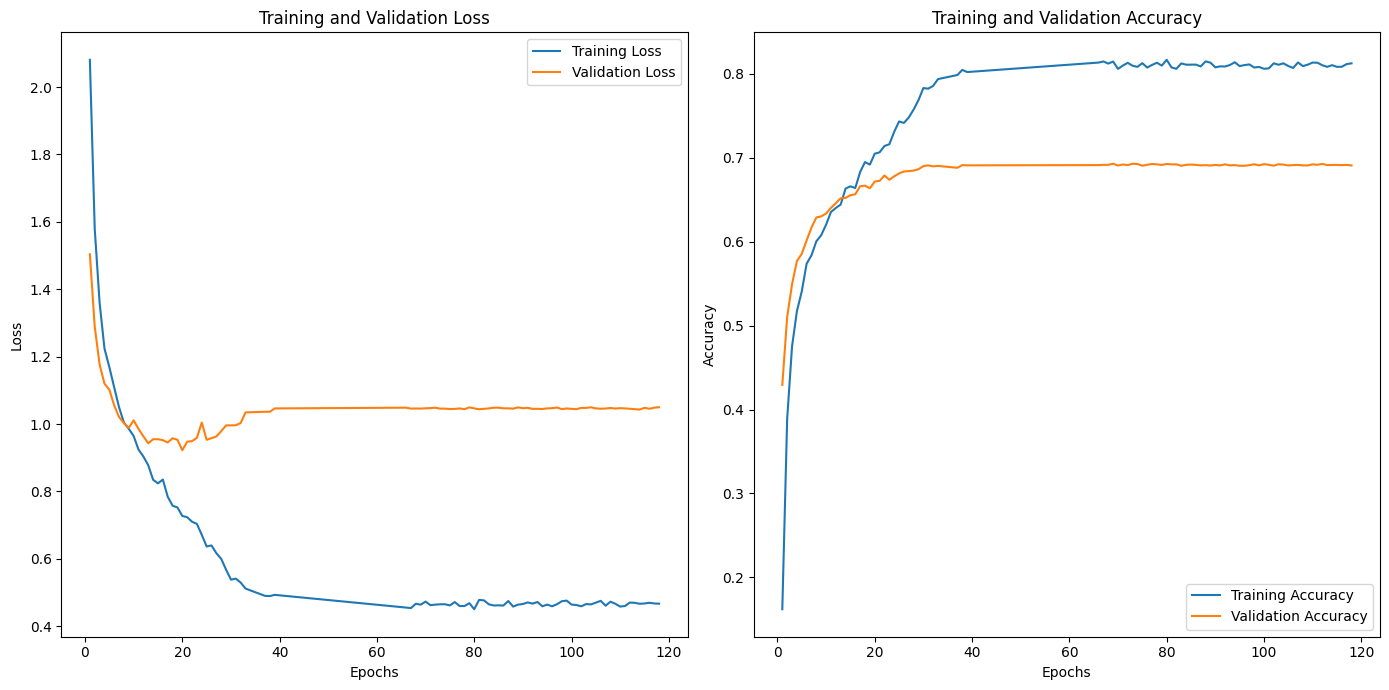

In [12]:
import re
import matplotlib.pyplot as plt

# Given log data
log_data = """
Epoch 1/200
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1721734001.086687     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 96/898 ━━━━━━━━━━━━━━━━━━━━ 11:16 844ms/step - accuracy: 0.1620 - loss: 2.0809
W0000 00:00:1721734081.416767     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.2096 - loss: 1.9035
Epoch 1: val_loss improved from inf to 1.50390, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 559s 546ms/step - accuracy: 0.2097 - loss: 1.9034 - val_accuracy: 0.4294 - val_loss: 1.5039 - learning_rate: 1.0000e-04
Epoch 2/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3889 - loss: 1.5793
Epoch 2: val_loss improved from 1.50390 to 1.28939, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 339s 375ms/step - accuracy: 0.3890 - loss: 1.5792 - val_accuracy: 0.5103 - val_loss: 1.2894 - learning_rate: 1.0000e-04
Epoch 3/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4752 - loss: 1.3601
Epoch 3: val_loss improved from 1.28939 to 1.17683, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 374ms/step - accuracy: 0.4752 - loss: 1.3601 - val_accuracy: 0.5493 - val_loss: 1.1768 - learning_rate: 1.0000e-04
Epoch 4/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5172 - loss: 1.2243
Epoch 4: val_loss improved from 1.17683 to 1.11981, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 374ms/step - accuracy: 0.5172 - loss: 1.2244 - val_accuracy: 0.5770 - val_loss: 1.1198 - learning_rate: 1.0000e-04
Epoch 5/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5408 - loss: 1.1691
Epoch 5: val_loss improved from 1.11981 to 1.10193, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 373ms/step - accuracy: 0.5408 - loss: 1.1691 - val_accuracy: 0.5857 - val_loss: 1.1019 - learning_rate: 1.0000e-04
Epoch 6/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5739 - loss: 1.1088
Epoch 6: val_loss improved from 1.10193 to 1.05540, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 373ms/step - accuracy: 0.5739 - loss: 1.1088 - val_accuracy: 0.6016 - val_loss: 1.0554 - learning_rate: 1.0000e-04
Epoch 7/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5839 - loss: 1.0497
Epoch 7: val_loss improved from 1.05540 to 1.02078, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.5839 - loss: 1.0497 - val_accuracy: 0.6169 - val_loss: 1.0208 - learning_rate: 1.0000e-04
Epoch 8/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6006 - loss: 1.0042
Epoch 8: val_loss improved from 1.02078 to 1.00239, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 341s 376ms/step - accuracy: 0.6006 - loss: 1.0043 - val_accuracy: 0.6290 - val_loss: 1.0024 - learning_rate: 1.0000e-04
Epoch 9/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6079 - loss: 0.9859
Epoch 9: val_loss improved from 1.00239 to 0.98856, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 341s 376ms/step - accuracy: 0.6079 - loss: 0.9859 - val_accuracy: 0.6303 - val_loss: 0.9886 - learning_rate: 1.0000e-04
Epoch 10/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6204 - loss: 0.9644
Epoch 10: val_loss did not improve from 0.98856
898/898 ━━━━━━━━━━━━━━━━━━━━ 341s 377ms/step - accuracy: 0.6204 - loss: 0.9644 - val_accuracy: 0.6337 - val_loss: 1.0109 - learning_rate: 1.0000e-04
Epoch 11/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6355 - loss: 0.9242
Epoch 11: val_loss improved from 0.98856 to 0.98541, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 343s 379ms/step - accuracy: 0.6355 - loss: 0.9242 - val_accuracy: 0.6404 - val_loss: 0.9854 - learning_rate: 1.0000e-04
Epoch 12/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6403 - loss: 0.9036
Epoch 12: val_loss improved from 0.98541 to 0.96364, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.6403 - loss: 0.9036 - val_accuracy: 0.6460 - val_loss: 0.9636 - learning_rate: 1.0000e-04
Epoch 13/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6444 - loss: 0.8777
Epoch 13: val_loss improved from 0.96364 to 0.94278, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 378s 376ms/step - accuracy: 0.6444 - loss: 0.8777 - val_accuracy: 0.6519 - val_loss: 0.9428 - learning_rate: 1.0000e-04
Epoch 14/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6634 - loss: 0.8346
Epoch 14: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 340s 376ms/step - accuracy: 0.6634 - loss: 0.8346 - val_accuracy: 0.6523 - val_loss: 0.9548 - learning_rate: 1.0000e-04
Epoch 15/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6661 - loss: 0.8240
Epoch 15: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 371ms/step - accuracy: 0.6661 - loss: 0.8240 - val_accuracy: 0.6555 - val_loss: 0.9549 - learning_rate: 1.0000e-04
Epoch 16/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6641 - loss: 0.8351
Epoch 16: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 339s 374ms/step - accuracy: 0.6641 - loss: 0.8351 - val_accuracy: 0.6566 - val_loss: 0.9522 - learning_rate: 1.0000e-04
Epoch 17/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6832 - loss: 0.7843
Epoch 17: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 341s 377ms/step - accuracy: 0.6832 - loss: 0.7843 - val_accuracy: 0.6662 - val_loss: 0.9452 - learning_rate: 1.0000e-04
Epoch 18/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6950 - loss: 0.7577
Epoch 18: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.6950 - loss: 0.7577 - val_accuracy: 0.6669 - val_loss: 0.9577 - learning_rate: 1.0000e-04
Epoch 19/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6920 - loss: 0.7524
Epoch 19: val_loss did not improve from 0.94278
898/898 ━━━━━━━━━━━━━━━━━━━━ 340s 375ms/step - accuracy: 0.6920 - loss: 0.7524 - val_accuracy: 0.6638 - val_loss: 0.9533 - learning_rate: 1.0000e-04
Epoch 20/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7050 - loss: 0.7272
Epoch 20: val_loss improved from 0.94278 to 0.92223, saving model to /kaggle/working/ResNet50_model_v1_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 343s 379ms/step - accuracy: 0.7049 - loss: 0.7272 - val_accuracy: 0.6718 - val_loss: 0.9222 - learning_rate: 1.0000e-04
Epoch 21/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7066 - loss: 0.7235
Epoch 21: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 339s 375ms/step - accuracy: 0.7066 - loss: 0.7235 - val_accuracy: 0.6726 - val_loss: 0.9475 - learning_rate: 1.0000e-04
Epoch 22/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7142 - loss: 0.7101
Epoch 22: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 381ms/step - accuracy: 0.7142 - loss: 0.7101 - val_accuracy: 0.6790 - val_loss: 0.9493 - learning_rate: 1.0000e-04
Epoch 23/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7162 - loss: 0.7036
Epoch 23: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 350s 386ms/step - accuracy: 0.7162 - loss: 0.7036 - val_accuracy: 0.6739 - val_loss: 0.9590 - learning_rate: 1.0000e-04
Epoch 24/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7311 - loss: 0.6712
Epoch 24: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 343s 379ms/step - accuracy: 0.7311 - loss: 0.6712 - val_accuracy: 0.6780 - val_loss: 1.0044 - learning_rate: 1.0000e-04
Epoch 25/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7434 - loss: 0.6367
Epoch 25: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 340s 376ms/step - accuracy: 0.7434 - loss: 0.6367 - val_accuracy: 0.6815 - val_loss: 0.9533 - learning_rate: 1.0000e-04
Epoch 26/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7417 - loss: 0.6396
Epoch 26: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 341s 377ms/step - accuracy: 0.7417 - loss: 0.6396 - val_accuracy: 0.6838 - val_loss: 0.9579 - learning_rate: 1.0000e-04
Epoch 27/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7482 - loss: 0.6166
Epoch 27: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.7482 - loss: 0.6166 - val_accuracy: 0.6842 - val_loss: 0.9632 - learning_rate: 1.0000e-04
Epoch 28/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7577 - loss: 0.5998
Epoch 28: val_loss did not improve from 0.92223

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.7577 - loss: 0.5998 - val_accuracy: 0.6849 - val_loss: 0.9789 - learning_rate: 1.0000e-04
Epoch 29/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7690 - loss: 0.5678
Epoch 29: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 345s 381ms/step - accuracy: 0.7690 - loss: 0.5678 - val_accuracy: 0.6865 - val_loss: 0.9960 - learning_rate: 2.0000e-05
Epoch 30/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7832 - loss: 0.5382
Epoch 30: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.7832 - loss: 0.5382 - val_accuracy: 0.6902 - val_loss: 0.9960 - learning_rate: 2.0000e-05
Epoch 31/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7825 - loss: 0.5411
Epoch 31: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 342s 378ms/step - accuracy: 0.7825 - loss: 0.5411 - val_accuracy: 0.6911 - val_loss: 0.9964 - learning_rate: 2.0000e-05
Epoch 32/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7858 - loss: 0.5295
Epoch 32: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 390s 387ms/step - accuracy: 0.7858 - loss: 0.5295 - val_accuracy: 0.6899 - val_loss: 1.0031 - learning_rate: 2.0000e-05
Epoch 33/200
796/898 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.7939 - loss: 0.5116
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8004 - loss: 0.4947
Epoch 36: val_loss did not improve from 0.92223

Epoch 36: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
898/898 ━━━━━━━━━━━━━━━━━━━━ 345s 382ms/step - accuracy: 0.8004 - loss: 0.4947 - val_accuracy: 0.6904 - val_loss: 1.0344 - learning_rate: 2.0000e-05
Epoch 37/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7988 - loss: 0.4900
Epoch 37: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 342s 378ms/step - accuracy: 0.7988 - loss: 0.4900 - val_accuracy: 0.6882 - val_loss: 1.0364 - learning_rate: 4.0000e-06
Epoch 38/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8049 - loss: 0.4895
Epoch 38: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 343s 379ms/step - accuracy: 0.8049 - loss: 0.4895 - val_accuracy: 0.6914 - val_loss: 1.0363 - learning_rate: 4.0000e-06
Epoch 39/200
482/898 ━━━━━━━━━━━━━━━━━━━━ 2:29 360ms/step - accuracy: 0.8023 - loss: 0.4930
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8087 - loss: 0.4656
Epoch 65: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 372ms/step - accuracy: 0.8087 - loss: 0.4656 - val_accuracy: 0.6911 - val_loss: 1.0463 - learning_rate: 3.2000e-08
Epoch 66/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8136 - loss: 0.4553
Epoch 66: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8136 - loss: 0.4553 - val_accuracy: 0.6914 - val_loss: 1.0485 - learning_rate: 3.2000e-08
Epoch 67/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8149 - loss: 0.4538
Epoch 67: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8149 - loss: 0.4538 - val_accuracy: 0.6917 - val_loss: 1.0458 - learning_rate: 3.2000e-08
Epoch 68/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8124 - loss: 0.4667
Epoch 68: val_loss did not improve from 0.92223

Epoch 68: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8124 - loss: 0.4667 - val_accuracy: 0.6917 - val_loss: 1.0461 - learning_rate: 3.2000e-08
Epoch 69/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8148 - loss: 0.4639
Epoch 69: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 372ms/step - accuracy: 0.8148 - loss: 0.4639 - val_accuracy: 0.6930 - val_loss: 1.0458 - learning_rate: 6.4000e-09
Epoch 70/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8061 - loss: 0.4730
Epoch 70: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 372ms/step - accuracy: 0.8061 - loss: 0.4729 - val_accuracy: 0.6909 - val_loss: 1.0467 - learning_rate: 6.4000e-09
Epoch 71/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8100 - loss: 0.4624
Epoch 71: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 371ms/step - accuracy: 0.8100 - loss: 0.4624 - val_accuracy: 0.6921 - val_loss: 1.0472 - learning_rate: 6.4000e-09
Epoch 72/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8133 - loss: 0.4640
Epoch 72: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8132 - loss: 0.4640 - val_accuracy: 0.6914 - val_loss: 1.0485 - learning_rate: 6.4000e-09
Epoch 73/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8098 - loss: 0.4650
Epoch 73: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 349s 386ms/step - accuracy: 0.8098 - loss: 0.4650 - val_accuracy: 0.6930 - val_loss: 1.0456 - learning_rate: 6.4000e-09
Epoch 74/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8085 - loss: 0.4651
Epoch 74: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8085 - loss: 0.4651 - val_accuracy: 0.6927 - val_loss: 1.0457 - learning_rate: 6.4000e-09
Epoch 75/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8129 - loss: 0.4617
Epoch 75: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 384s 373ms/step - accuracy: 0.8129 - loss: 0.4617 - val_accuracy: 0.6907 - val_loss: 1.0444 - learning_rate: 6.4000e-09
Epoch 76/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8077 - loss: 0.4717
Epoch 76: val_loss did not improve from 0.92223

Epoch 76: ReduceLROnPlateau reducing learning rate to 1.279999928271991e-09.
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 374ms/step - accuracy: 0.8077 - loss: 0.4717 - val_accuracy: 0.6918 - val_loss: 1.0448 - learning_rate: 6.4000e-09
Epoch 77/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8108 - loss: 0.4598
Epoch 77: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8108 - loss: 0.4598 - val_accuracy: 0.6927 - val_loss: 1.0463 - learning_rate: 1.2800e-09
Epoch 78/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8134 - loss: 0.4599
Epoch 78: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 339s 374ms/step - accuracy: 0.8134 - loss: 0.4599 - val_accuracy: 0.6923 - val_loss: 1.0440 - learning_rate: 1.2800e-09
Epoch 79/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8100 - loss: 0.4683
Epoch 79: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 373ms/step - accuracy: 0.8100 - loss: 0.4683 - val_accuracy: 0.6916 - val_loss: 1.0494 - learning_rate: 1.2800e-09
Epoch 80/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8169 - loss: 0.4503
Epoch 80: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 372ms/step - accuracy: 0.8169 - loss: 0.4503 - val_accuracy: 0.6927 - val_loss: 1.0464 - learning_rate: 1.2800e-09
Epoch 81/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8078 - loss: 0.4780
Epoch 81: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 354s 392ms/step - accuracy: 0.8078 - loss: 0.4779 - val_accuracy: 0.6923 - val_loss: 1.0438 - learning_rate: 1.2800e-09
Epoch 82/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8062 - loss: 0.4767
Epoch 82: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 358s 395ms/step - accuracy: 0.8062 - loss: 0.4767 - val_accuracy: 0.6923 - val_loss: 1.0451 - learning_rate: 1.2800e-09
Epoch 83/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8126 - loss: 0.4650
Epoch 83: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 350s 387ms/step - accuracy: 0.8126 - loss: 0.4650 - val_accuracy: 0.6906 - val_loss: 1.0463 - learning_rate: 1.2800e-09
Epoch 84/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8111 - loss: 0.4615
Epoch 84: val_loss did not improve from 0.92223

Epoch 84: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 372ms/step - accuracy: 0.8111 - loss: 0.4615 - val_accuracy: 0.6917 - val_loss: 1.0485 - learning_rate: 1.2800e-09
Epoch 85/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8111 - loss: 0.4619
Epoch 85: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8111 - loss: 0.4619 - val_accuracy: 0.6920 - val_loss: 1.0484 - learning_rate: 2.5600e-10
Epoch 86/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8112 - loss: 0.4613
Epoch 86: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8112 - loss: 0.4613 - val_accuracy: 0.6917 - val_loss: 1.0466 - learning_rate: 2.5600e-10
Epoch 87/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8090 - loss: 0.4747
Epoch 87: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 334s 369ms/step - accuracy: 0.8090 - loss: 0.4747 - val_accuracy: 0.6911 - val_loss: 1.0466 - learning_rate: 2.5600e-10
Epoch 88/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8150 - loss: 0.4582
Epoch 88: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 373ms/step - accuracy: 0.8150 - loss: 0.4582 - val_accuracy: 0.6913 - val_loss: 1.0456 - learning_rate: 2.5600e-10
Epoch 89/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8135 - loss: 0.4639
Epoch 89: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 335s 370ms/step - accuracy: 0.8135 - loss: 0.4639 - val_accuracy: 0.6909 - val_loss: 1.0493 - learning_rate: 2.5600e-10
Epoch 90/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8079 - loss: 0.4659
Epoch 90: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 371ms/step - accuracy: 0.8079 - loss: 0.4659 - val_accuracy: 0.6916 - val_loss: 1.0470 - learning_rate: 2.5600e-10
Epoch 91/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8091 - loss: 0.4705
Epoch 91: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 362s 400ms/step - accuracy: 0.8091 - loss: 0.4705 - val_accuracy: 0.6910 - val_loss: 1.0480 - learning_rate: 2.5600e-10
Epoch 92/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8089 - loss: 0.4670
Epoch 92: val_loss did not improve from 0.92223

Epoch 92: ReduceLROnPlateau reducing learning rate to 5.119999424429978e-11.
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 372ms/step - accuracy: 0.8089 - loss: 0.4670 - val_accuracy: 0.6923 - val_loss: 1.0449 - learning_rate: 2.5600e-10
Epoch 93/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8107 - loss: 0.4718
Epoch 93: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 339s 374ms/step - accuracy: 0.8107 - loss: 0.4718 - val_accuracy: 0.6910 - val_loss: 1.0452 - learning_rate: 5.1200e-11
Epoch 94/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8140 - loss: 0.4591
Epoch 94: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 340s 376ms/step - accuracy: 0.8140 - loss: 0.4591 - val_accuracy: 0.6914 - val_loss: 1.0445 - learning_rate: 5.1200e-11
Epoch 95/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8094 - loss: 0.4641
Epoch 95: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 342s 378ms/step - accuracy: 0.8094 - loss: 0.4641 - val_accuracy: 0.6906 - val_loss: 1.0464 - learning_rate: 5.1200e-11
Epoch 96/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8106 - loss: 0.4591
Epoch 96: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 372s 411ms/step - accuracy: 0.8106 - loss: 0.4591 - val_accuracy: 0.6906 - val_loss: 1.0470 - learning_rate: 5.1200e-11
Epoch 97/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8114 - loss: 0.4651
Epoch 97: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 371s 410ms/step - accuracy: 0.8114 - loss: 0.4651 - val_accuracy: 0.6913 - val_loss: 1.0489 - learning_rate: 5.1200e-11
Epoch 98/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8077 - loss: 0.4740
Epoch 98: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 377s 417ms/step - accuracy: 0.8077 - loss: 0.4740 - val_accuracy: 0.6924 - val_loss: 1.0442 - learning_rate: 5.1200e-11
Epoch 99/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8084 - loss: 0.4760
Epoch 99: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 382s 422ms/step - accuracy: 0.8084 - loss: 0.4759 - val_accuracy: 0.6911 - val_loss: 1.0462 - learning_rate: 5.1200e-11
Epoch 100/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8062 - loss: 0.4642
Epoch 100: val_loss did not improve from 0.92223

Epoch 100: ReduceLROnPlateau reducing learning rate to 1.0239999126415712e-11.
898/898 ━━━━━━━━━━━━━━━━━━━━ 365s 403ms/step - accuracy: 0.8062 - loss: 0.4642 - val_accuracy: 0.6925 - val_loss: 1.0450 - learning_rate: 5.1200e-11
Epoch 101/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8067 - loss: 0.4629
Epoch 101: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 355s 392ms/step - accuracy: 0.8067 - loss: 0.4629 - val_accuracy: 0.6918 - val_loss: 1.0440 - learning_rate: 1.0240e-11
Epoch 102/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8127 - loss: 0.4590
Epoch 102: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 354s 391ms/step - accuracy: 0.8127 - loss: 0.4590 - val_accuracy: 0.6907 - val_loss: 1.0479 - learning_rate: 1.0240e-11
Epoch 103/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8110 - loss: 0.4657
Epoch 103: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 353s 390ms/step - accuracy: 0.8110 - loss: 0.4657 - val_accuracy: 0.6924 - val_loss: 1.0478 - learning_rate: 1.0240e-11
Epoch 104/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8127 - loss: 0.4647
Epoch 104: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 354s 391ms/step - accuracy: 0.8127 - loss: 0.4647 - val_accuracy: 0.6920 - val_loss: 1.0496 - learning_rate: 1.0240e-11
Epoch 105/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8095 - loss: 0.4700
Epoch 105: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 354s 391ms/step - accuracy: 0.8095 - loss: 0.4700 - val_accuracy: 0.6910 - val_loss: 1.0464 - learning_rate: 1.0240e-11
Epoch 106/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8072 - loss: 0.4752
Epoch 106: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 356s 394ms/step - accuracy: 0.8072 - loss: 0.4752 - val_accuracy: 0.6914 - val_loss: 1.0455 - learning_rate: 1.0240e-11
Epoch 107/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8137 - loss: 0.4609
Epoch 107: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 358s 395ms/step - accuracy: 0.8137 - loss: 0.4609 - val_accuracy: 0.6916 - val_loss: 1.0459 - learning_rate: 1.0240e-11
Epoch 108/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8094 - loss: 0.4727
Epoch 108: val_loss did not improve from 0.92223

Epoch 108: ReduceLROnPlateau reducing learning rate to 2.0479997905886727e-12.
898/898 ━━━━━━━━━━━━━━━━━━━━ 355s 392ms/step - accuracy: 0.8094 - loss: 0.4727 - val_accuracy: 0.6911 - val_loss: 1.0476 - learning_rate: 1.0240e-11
Epoch 109/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8111 - loss: 0.4667
Epoch 109: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 367s 405ms/step - accuracy: 0.8111 - loss: 0.4667 - val_accuracy: 0.6910 - val_loss: 1.0459 - learning_rate: 2.0480e-12
Epoch 110/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8136 - loss: 0.4582
Epoch 110: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 370s 409ms/step - accuracy: 0.8136 - loss: 0.4582 - val_accuracy: 0.6923 - val_loss: 1.0471 - learning_rate: 2.0480e-12
Epoch 111/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8134 - loss: 0.4600
Epoch 111: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 369s 408ms/step - accuracy: 0.8134 - loss: 0.4600 - val_accuracy: 0.6918 - val_loss: 1.0463 - learning_rate: 2.0480e-12
Epoch 112/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8104 - loss: 0.4701
Epoch 112: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 367s 406ms/step - accuracy: 0.8104 - loss: 0.4701 - val_accuracy: 0.6928 - val_loss: 1.0453 - learning_rate: 2.0480e-12
Epoch 113/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8085 - loss: 0.4694
Epoch 113: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 373s 412ms/step - accuracy: 0.8085 - loss: 0.4694 - val_accuracy: 0.6914 - val_loss: 1.0441 - learning_rate: 2.0480e-12
Epoch 114/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8105 - loss: 0.4666
Epoch 114: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 364s 402ms/step - accuracy: 0.8105 - loss: 0.4666 - val_accuracy: 0.6916 - val_loss: 1.0429 - learning_rate: 2.0480e-12
Epoch 115/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8085 - loss: 0.4674
Epoch 115: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 353s 390ms/step - accuracy: 0.8085 - loss: 0.4674 - val_accuracy: 0.6916 - val_loss: 1.0481 - learning_rate: 2.0480e-12
Epoch 116/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8086 - loss: 0.4695
Epoch 116: val_loss did not improve from 0.92223

Epoch 116: ReduceLROnPlateau reducing learning rate to 4.0959995811773456e-13.
898/898 ━━━━━━━━━━━━━━━━━━━━ 366s 404ms/step - accuracy: 0.8086 - loss: 0.4695 - val_accuracy: 0.6914 - val_loss: 1.0454 - learning_rate: 2.0480e-12
Epoch 117/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8118 - loss: 0.4675
Epoch 117: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 373s 412ms/step - accuracy: 0.8118 - loss: 0.4675 - val_accuracy: 0.6916 - val_loss: 1.0485 - learning_rate: 4.0960e-13
Epoch 118/200
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8127 - loss: 0.4668
Epoch 118: val_loss did not improve from 0.92223
898/898 ━━━━━━━━━━━━━━━━━━━━ 372s 411ms/step - accuracy: 0.8127 - loss: 0.4668 - val_accuracy: 0.6910 - val_loss: 1.0498 - learning_rate: 4.0960e-13
Epoch 119/200
787/898 ━━━━━━━━━━━━━━━━━━━━ 44s 402ms/step - accuracy: 0.8126 - loss: 0.4658
"""



# Regular expression to extract the relevant metrics
pattern = r"Epoch (\d+)/\d+.*?accuracy: (\d+\.\d+).*?loss: (\d+\.\d+).*?val_accuracy: (\d+\.\d+).*?val_loss: (\d+\.\d+)"

# Find all matches
matches = re.findall(pattern, log_data, re.DOTALL)

# Extracted data
epochs = []
loss = []
val_loss = []
accuracy = []
val_accuracy = []

for match in matches:
    epochs.append(int(match[0]))
    accuracy.append(float(match[1]))
    loss.append(float(match[2]))
    val_accuracy.append(float(match[3]))
    val_loss.append(float(match[4]))

# Plotting
plt.figure(figsize=(14, 7))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:

!pip install plotly
import plotly.graph_objects as go

# Create figure for loss
fig_loss = go.Figure()

# Add traces for loss
fig_loss.add_trace(go.Scatter(x=epochs, y=loss, mode='lines+markers', name='Training Loss'))
fig_loss.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'))

# Update layout for loss
fig_loss.update_layout(title='Training and Validation Loss',
                       xaxis_title='Epochs',
                       yaxis_title='Loss')

# Show loss figure
fig_loss.show()

# Create figure for accuracy
fig_accuracy = go.Figure()

# Add traces for accuracy
fig_accuracy.add_trace(go.Scatter(x=epochs, y=accuracy, mode='lines+markers', name='Training Accuracy'))
fig_accuracy.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))

# Update layout for accuracy
fig_accuracy.update_layout(title='Training and Validation Accuracy',
                           xaxis_title='Epochs',
                           yaxis_title='Accuracy')

# Show accuracy figure
fig_accuracy.show()


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


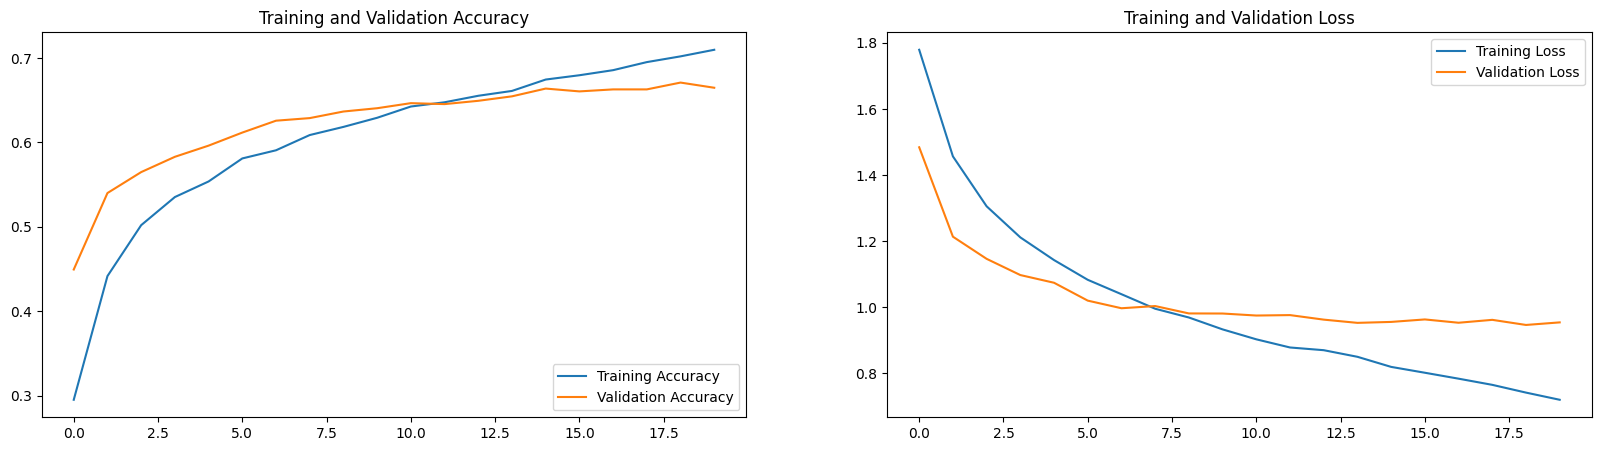

In [14]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    
plot_training_history(train_history)

In [15]:
# Evaluate the model on the test data to get the initial loss and accuracy
initial_loss, initial_accuracy = model.evaluate(test_generator, verbose=2)

# Print the initial loss and accuracy
print(f"Initial loss: {initial_loss}")
print(f"Initial accuracy: {initial_accuracy}")

225/225 - 10s - 46ms/step - accuracy: 0.6648 - loss: 0.9543
Initial loss: 0.9543418288230896
Initial accuracy: 0.6648091673851013


In [16]:
# Evaluate the model on the training data
train_loss, train_accu = model.evaluate(train_generator)
# Evaluate the model on the test data
test_loss, test_accu = model.evaluate(test_generator)

# Print the final training and validation accuracy
print("Final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu * 100, test_accu * 100))

898/898 ━━━━━━━━━━━━━━━━━━━━ 312s 348ms/step - accuracy: 0.7487 - loss: 0.6800
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6598 - loss: 0.9700
Final train accuracy = 75.12 , validation accuracy = 66.48


225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step


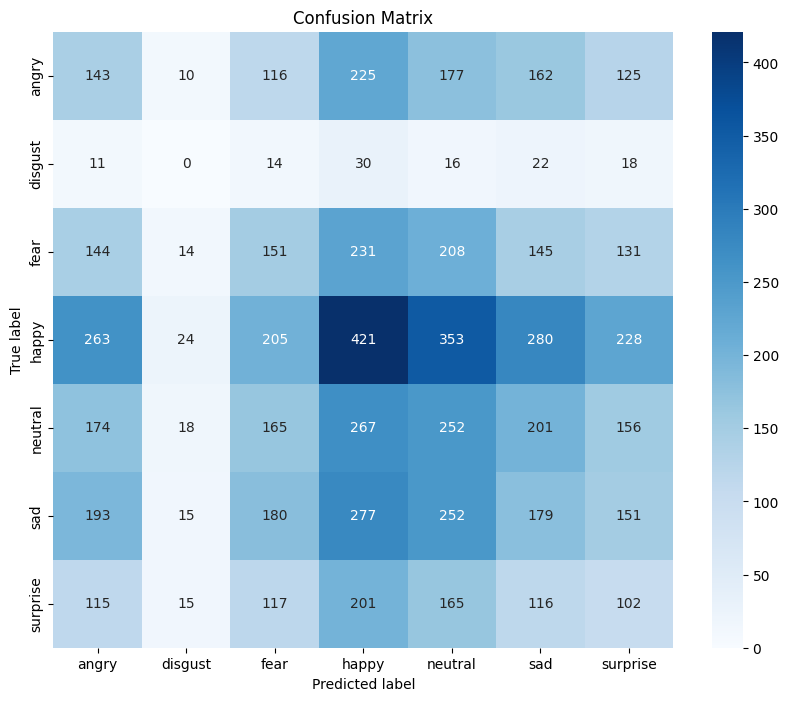

In [17]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(model.predict(test_generator, steps=steps), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [18]:
# Printing the classification report
ResNet50_model_v1_report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", ResNet50_model_v1_report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.15      0.15      1024
       happy       0.25      0.24      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.11      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.17      0.17      7178



In [19]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step


In [21]:
import pandas as pd

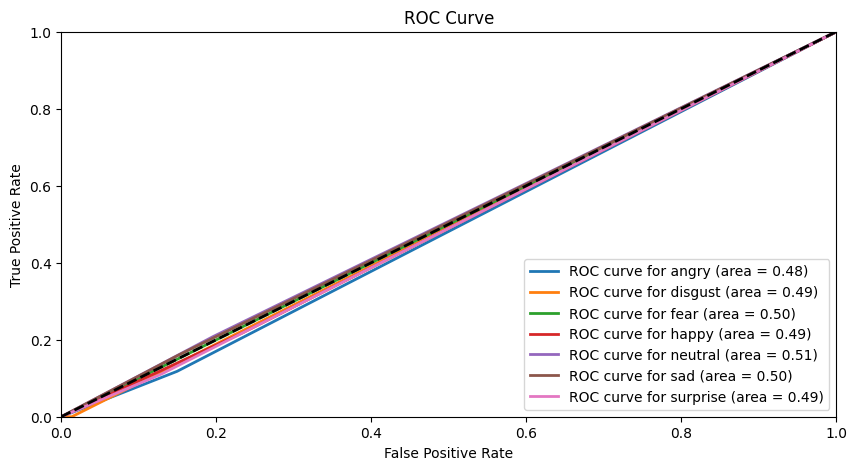

In [22]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')